In [19]:
import os 
import time
import copy
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import ishermitian
import pandas as pd

from joblib import Parallel, delayed
from numba import jit, njit, prange
import functools as ft

np.random.seed(0)

In [20]:
# Load test coefficients
K=7
J=4
q=4

N = 2*K
n_dim = 2**K

fname = 'test_coefficients_K{}_J{}_q{}.csv'.format(K,J,q)

test_js = np.fromfile(fname, sep = ',').reshape(tuple([N for i in range(q)]))
test_js[0,0,0]

array([ 0.32995524,  0.07484697,  0.18306698,  0.41914542,  0.34931534,
       -0.18279387,  0.17770825, -0.02831044, -0.01930646,  0.07679995,
        0.02694247,  0.272013  ,  0.14234747,  0.02275857])

## 1. Define fermionic modes

In [21]:
cr = np.array([[0,1],[0,0]])
an = np.array([[0,0],[1,0]])
id = np.identity(2)
id2 = np.array([[-1,0],[0,1]])

def c(n, K):
    factors = [id for i in range(n-1)]+[cr]+[id2 for i in range(K-n)]
    out = factors[0]
    for i in range(1, K):
        out = np.kron(out,factors[i])
    return out

def cd(n, K):
    factors = [id for i in range(n-1)]+[an]+[id2 for i in range(K-n)]
    out = factors[0]
    for i in range(1, K):
        out = np.kron(out,factors[i])
    return out

### 1.a. Check fermionic modes satisfy algebra

$\{c_i, c_j\}=\{c_i^\dagger, c_j^\dagger\}=0$,     $\{c_i,c_j^\dagger\}=\delta_{ij}$

In [22]:
def anticommutator(a,b):
    return a@b+b@a

c_algebra_satisfied = True
for i in range(1,K+1):
    c_i = c(i, K)
    cd_i = cd(i, K)

    for j in range(1,K+1):
        c_j = c(j, K)
        cd_j = cd(j, K)

        ac_ci_cj = anticommutator(c_i, c_j)
        if not np.allclose(ac_ci_cj, np.zeros((n_dim, n_dim))):
            c_algebra_satisfied = False
            print(f"Failure 1: i={i}, j={j}")

        ac_cdi_cdj = anticommutator(cd_i, cd_j)
        if not np.allclose(ac_cdi_cdj, np.zeros((n_dim, n_dim))):
            c_algebra_satisfied = False
            print(f"Failure 2: i={i}, j={j}")


        ac_ci_cdj = anticommutator(c_i, cd_j)
        if i==j:
            if not np.allclose(ac_ci_cdj, np.identity(n_dim)):
                c_algebra_satisfied = False
                print(f"Failure 3: i={i}, j={j}")

        else:
            if not np.allclose(ac_ci_cdj, np.zeros((n_dim, n_dim))):
                c_algebra_satisfied = False
                (f"Failure 4: i={i}, j={j}")

        
print(f"Algebra satisfied: {c_algebra_satisfied}")

Algebra satisfied: True


## 2. Define fermions

In [23]:
# Compute first N psi's
psi = np.zeros((N, n_dim, n_dim), dtype=np.complex128)
for i in range(1,K+1):
    psi[2*(i-1)] = (c(i, K)+cd(i, K))/np.sqrt(2)
    psi[2*(i-1)+1] = (c(i, K)-cd(i, K))*(-1j/np.sqrt(2))

### 2.a. Check that fermions satisfy algebra

$\{\psi_i, \psi_j\} = \delta_{ij}$

In [24]:
def anticommutator(a,b):
    return a@b+b@a

psi_algebra_satisfied = True
for i in range(N):
    psi_i = psi[i]

    for j in range(N):
        psi_j = psi[j]

        ac_pi_pj = anticommutator(psi_i, psi_j)

        if i==j:
            if not np.allclose(ac_pi_pj, np.identity(n_dim)):
                psi_algebra_satisfied = False
                print(f"Failure 1: i={i}, j={j}")
        else:
            if not np.allclose(ac_pi_pj, np.zeros((n_dim, n_dim))):
                psi_algebra_satisfied = False
                print(f"Failure 2: i={i}, j={j}")
        
print(f"Algebra satisfied: {psi_algebra_satisfied}")

Algebra satisfied: True


## 2. Pre-compute pairwise $\psi$ inner-products

In [25]:
# Compute pairwise inner products
psi_pairs = np.zeros((N, N, n_dim, n_dim), dtype=np.complex128)
for i in range(N):
    for j in range(i+1, N):
        psi_pairs[i, j] = psi[i]@psi[j]

## 3. Pre-compute quadwise inner products

In [26]:
psi_quads = np.zeros((N, N, N, N, n_dim, n_dim), dtype=np.complex64)
for i in range(N):
    for j in range(i+1, N):
        for k in range(j+1, N):
            for l in range(k+1, N):
                psi_quads[i, j, k, l] = psi_pairs[i,j]@psi_pairs[k,l]

print(f"test_js.shape: {test_js.shape}")
print(f"psi_quads.shape: {psi_quads.shape}")

test_js.shape: (14, 14, 14, 14)
psi_quads.shape: (14, 14, 14, 14, 128, 128)


## 4. Compute Hamiltonian

In [34]:
H = np.zeros((n_dim, n_dim), dtype=np.complex64)
for i in range(N):
    for j in range(i+1, N):
        for k in range(j+1, N):
            for l in range(k+1, N):
                H += (1j**(q/2))*test_js[i,j,k,l]*psi_quads[i,j,k,l]

Eigenvalues mostly real: True
[-2.7137291  -2.7137291  -2.5061498  -2.5061498  -2.3919394  -2.3919394
 -2.2853122  -2.2853122  -2.2267196  -2.2267196  -2.1089501  -2.1089501
 -2.0685828  -2.0685828  -1.9490799  -1.9490799  -1.9297954  -1.9297954
 -1.878345   -1.878345   -1.7533463  -1.7533463  -1.6339252  -1.6339252
 -1.5306541  -1.5306541  -1.4472272  -1.4472272  -1.3695805  -1.3695805
 -1.3361948  -1.3361948  -1.2429725  -1.2429725  -1.1162647  -1.1162647
 -1.0654917  -1.0654917  -0.9280027  -0.9280027  -0.88420045 -0.88420045
 -0.8172338  -0.8172338  -0.76443154 -0.76443154 -0.58825773 -0.58825773
 -0.5340219  -0.5340219  -0.4303501  -0.4303501  -0.4139338  -0.4139338
 -0.35249287 -0.35249287 -0.29932922 -0.29932922 -0.19663866 -0.19663866
 -0.10633302 -0.10633302 -0.00690897 -0.00690897  0.09732491  0.09732491
  0.14929888  0.14929888  0.19722888  0.19722888  0.27449903  0.27449903
  0.3341361   0.3341361   0.3916274   0.3916274   0.53649867  0.53649867
  0.6627846   0.6627846   0.

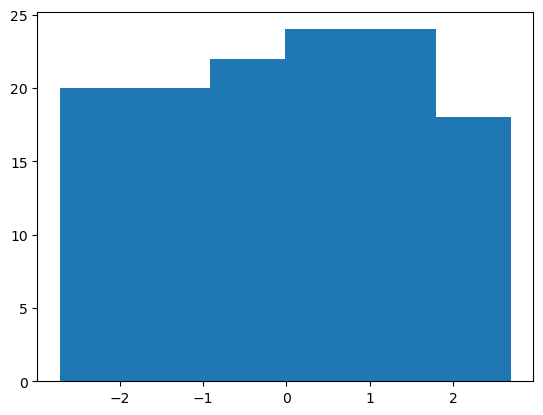

In [36]:
eigvals = np.linalg.eigvals(H)
print(f"Eigenvalues mostly real: {np.allclose(eigvals, np.real(eigvals))}")
plt.hist(eigvals, bins=6)
print(np.sort(eigvals.real))

Boom, exactly the same eigenvalues as the Mathematica method